In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
sector = pd.read_csv('sectors_walmart.csv', index_col='PID')
data = data.merge(sector[['Sector','DfromWalmart']], on='PID')
data.shape

(2579, 83)

In [4]:
# Define y as "SalePrice"
y = data.SalePrice.copy()

## Quick look at <span style="color:darkred">Sales Prices</span> 💵

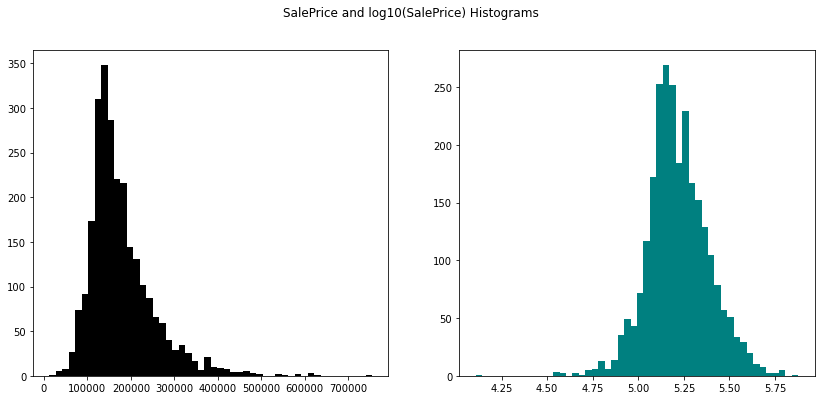

In [5]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('SalePrice and log10(SalePrice) Histograms')

ax1.hist(y, bins=50,color='k');
ax2.hist(np.log10(y), bins=50, color='teal');

# Type of House

####  MSSubClass: Type of dwelling
        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

#### Convert to:
    1Fl = 20,30,40,45,50
    2Fl = 60,70,75
    SPLIT = 80,85
    PUD1Fl = 120,150
    PUD2Fl = 160,180
    DUP2FAM = 90,190

In [6]:
conv_dict = {}
for k in [20,30,40,45,50]:
    conv_dict[k] = '1FL'
for k in [60,70,75]:
    conv_dict[k] = '2FL'
for k in [80,85]:
    conv_dict[k] = 'SPLIT'
for k in [120,150]:
    conv_dict[k] = 'PUD1Fl'
for k in [160,180]:
    conv_dict[k] = 'PUD2Fl'
for k in [90,190]:
    conv_dict[k] = 'DUP2FAM'

data.loc[:,'MSSubClass'] = data.loc[:,'MSSubClass'].apply(lambda r: conv_dict[r])

In [7]:
data.MSSubClass.value_counts().sort_index()

1FL        1343
2FL         639
DUP2FAM     140
PUD1Fl      170
PUD2Fl      135
SPLIT       152
Name: MSSubClass, dtype: int64

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

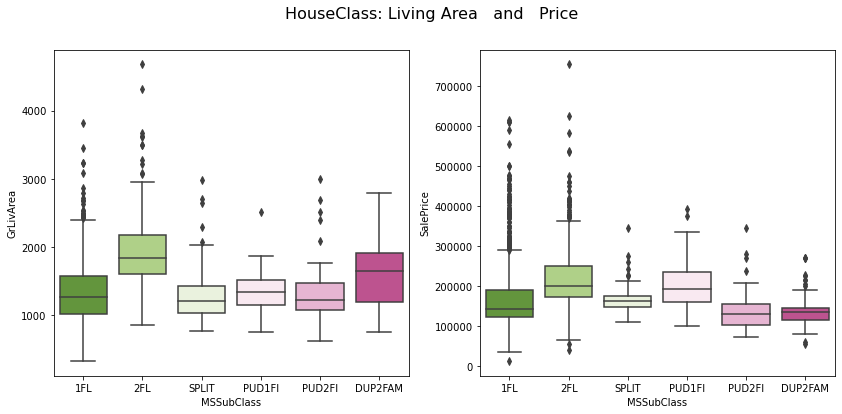

In [8]:
#Plot NEW HouseClass
sns.set_palette('PiYG_r')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('HouseClass: Living Area   and   Price', size=16)

sns.boxplot(ax=ax1,x=data.MSSubClass, y=data.GrLivArea)
sns.boxplot(ax=ax2,x=data.MSSubClass, y=y)

## 🤦‍♂️ David's: 
### GarageCars, BsmtQual

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

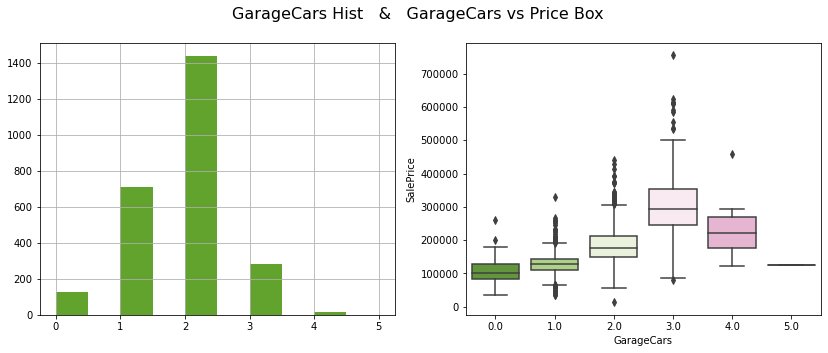

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('GarageCars Hist   &   GarageCars vs Price Box', size=16)

data['GarageCars'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['GarageCars'],y=y)

### <span style="color:Teal">Combine 4 & 5 into 3, and fill NaN with 0</span>

In [10]:
data['GarageCars'].replace({np.NaN:0,4:3,5:3}, inplace=True)

<AxesSubplot:xlabel='BsmtQual', ylabel='SalePrice'>

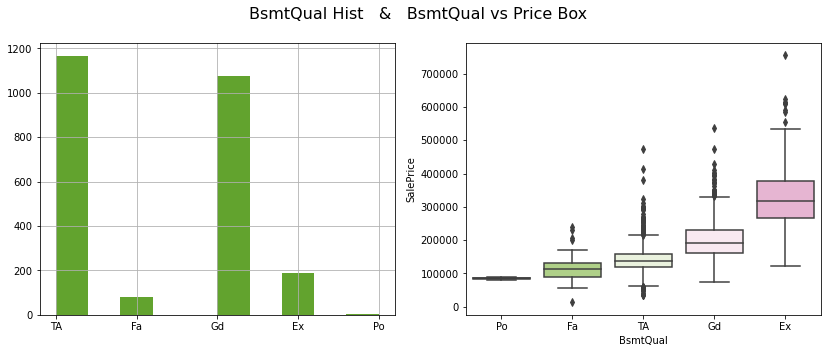

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('BsmtQual Hist   &   BsmtQual vs Price Box', size=16)

data['BsmtQual'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['BsmtQual'],y=y,order=['Po','Fa','TA','Gd','Ex'])

## 🤷‍♂️ Karl's: 
### Foundation, PavedDrive, BsmtFullBath + BsmtHalfBath + FullBath + HalfBath, BedroomAbvGr, TotRmsAbvGrd

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

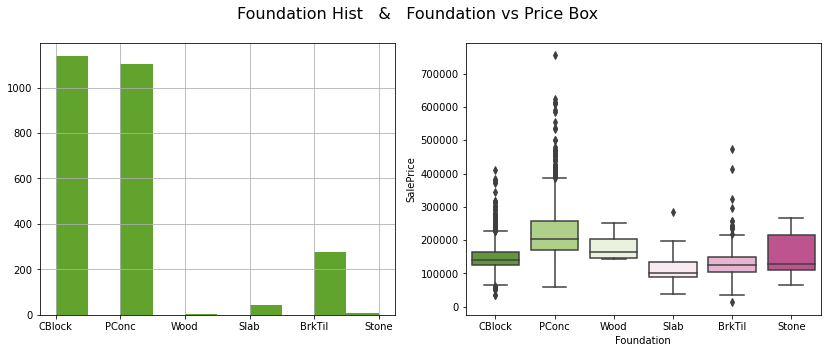

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Foundation Hist   &   Foundation vs Price Box', size=16)

data['Foundation'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['Foundation'],y=y)

<AxesSubplot:xlabel='PavedDrive', ylabel='SalePrice'>

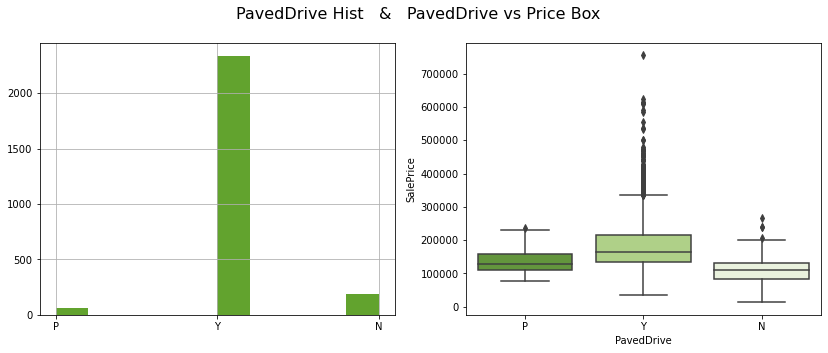

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('PavedDrive Hist   &   PavedDrive vs Price Box', size=16)

data['PavedDrive'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['PavedDrive'],y=y)

### 🐦NewFeat: <span style="color:Red">AllBath</span>  (fill NaN with 0)
* = BsmtFullBath + BsmtHalfBath + FullBath + HalfBath (Full = 1, Half = 0.5)

In [14]:
data['AllBath'] = data.BsmtFullBath + data.BsmtHalfBath/2 + data.FullBath + data.HalfBath/2
data['AllBath'].replace({np.NaN:0}, inplace=True)

<AxesSubplot:xlabel='AllBath', ylabel='SalePrice'>

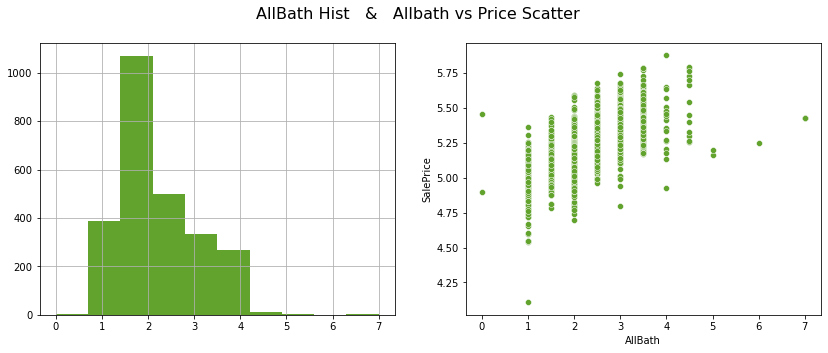

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('AllBath Hist   &   Allbath vs Price Scatter', size=16)

data['AllBath'].hist(ax=ax1)
sns.scatterplot(ax=ax2, x=data['AllBath'],y=np.log10(y))

### TotalBedrooms vs TotalAllRooms

<AxesSubplot:xlabel='BedroomAbvGr', ylabel='SalePrice'>

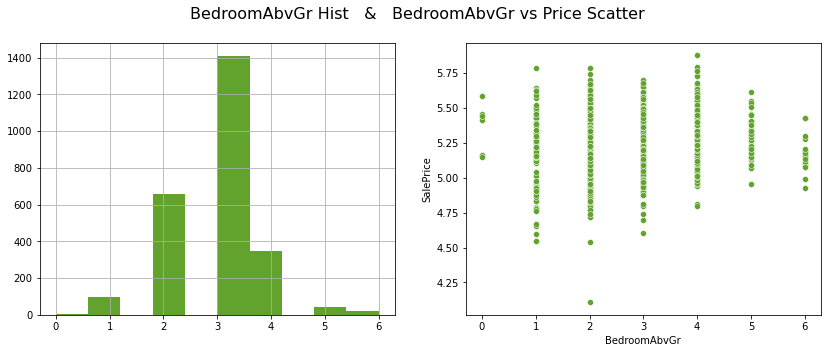

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('BedroomAbvGr Hist   &   BedroomAbvGr vs Price Scatter', size=16)

data['BedroomAbvGr'].hist(ax=ax1)
sns.scatterplot(ax=ax2, x=data['BedroomAbvGr'],y=np.log10(y))

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

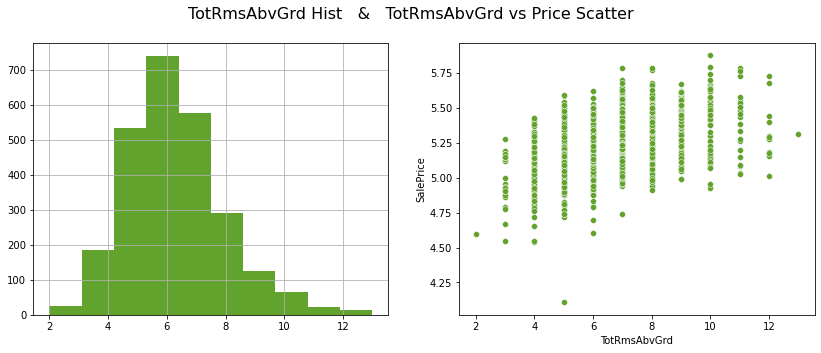

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('TotRmsAbvGrd Hist   &   TotRmsAbvGrd vs Price Scatter', size=16)

data['TotRmsAbvGrd'].hist(ax=ax1)
sns.scatterplot(ax=ax2, x=data['TotRmsAbvGrd'],y=np.log10(y))

## Total Rooms maybe better than only Bedrooms

## 🧏‍♂️ Tony's
### Fireplaces, HeatingQC

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

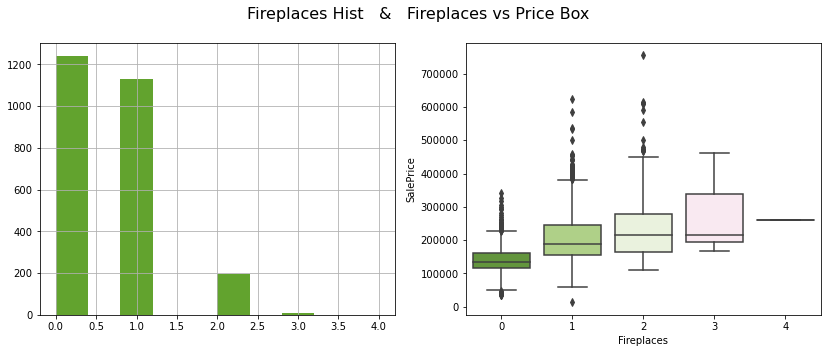

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Fireplaces Hist   &   Fireplaces vs Price Box', size=16)

data['Fireplaces'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['Fireplaces'],y=y)

### <span style="color:Teal">Combine 3 & 4 into 2, and fill NaN with 0</span>

In [19]:
data['Fireplaces'].replace({np.NaN:0,3:2,4:2}, inplace=True)

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

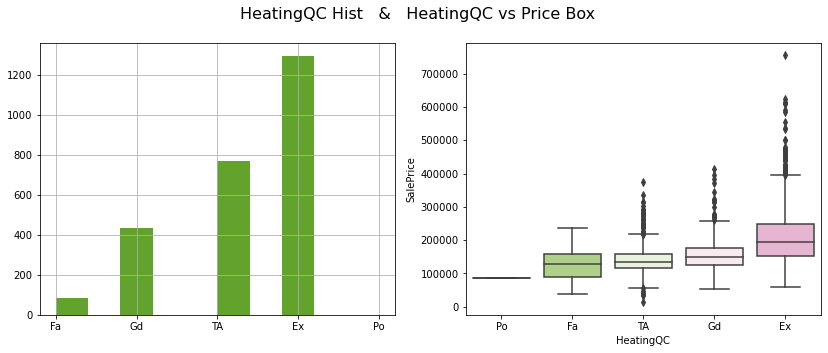

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('HeatingQC Hist   &   HeatingQC vs Price Box', size=16)

data['HeatingQC'].hist(ax=ax1)
sns.boxplot(ax=ax2, x=data['HeatingQC'],y=y, order=['Po','Fa','TA','Gd','Ex'])

## 👴 Daniel's
### Neighborhood, YearBuilt, OverallQual,

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

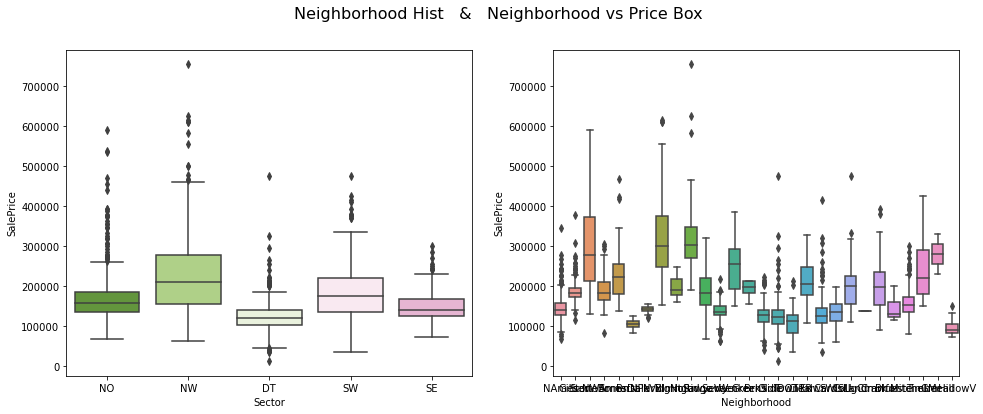

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Neighborhood Hist   &   Neighborhood vs Price Box', size=16)

sns.boxplot(ax=ax1, x=data['Sector'],y=y)
sns.boxplot(ax=ax2, x=data['Neighborhood'],y=y)

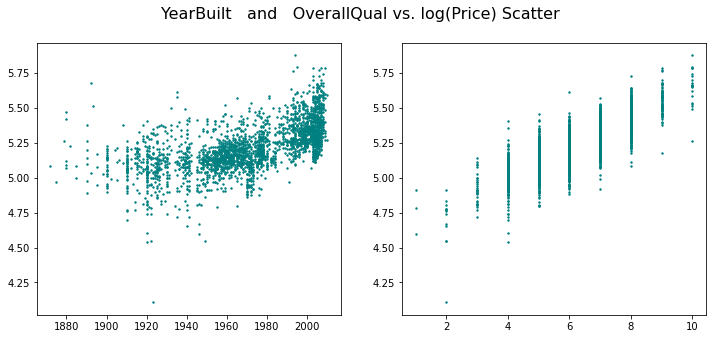

In [22]:
#Plot Year Built
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('YearBuilt   and   OverallQual vs. log(Price) Scatter', size=16)

ax1.scatter(x=data.YearBuilt,y=np.log10(y),s=2,c='teal')
ax2.scatter(x=data.OverallQual,y=np.log10(y),s=2,c='teal')

## <span style="color:darkred">Size Related</span> Features 📐 (continuous)
* Columns with "SF" / "AREA" / "Porch Size"

In [23]:
size_related = data.filter(regex='SF$|Area$|(Porch)')
size_related = size_related.fillna(0.0)  # We fill the very minor missing values by 0.0

### 🐦New Feat <span style="color:blue">PorchArea</span> (Sum of all Porch & Deck)
* WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

In [24]:
size_related['PorchArea'] = size_related[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

In [25]:
#Drop unnecessary columns
size_related.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)

<AxesSubplot:>

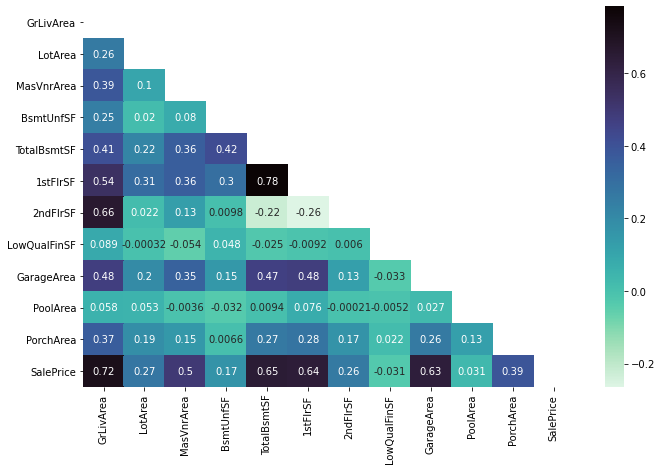

In [26]:
corr = pd.concat([size_related, y], axis=1).corr()

# Hide upper redundant heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(corr, mask=mask, annot=True, cmap='mako_r')

#### Investigate GrLivArea (largest correlation with Sale Price 0.72)

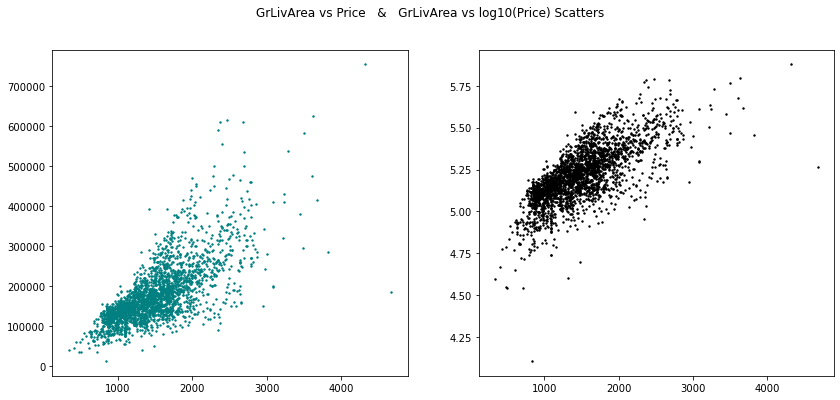

In [27]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('GrLivArea vs Price   &   GrLivArea vs log10(Price) Scatters')

ax1.scatter(x=size_related.GrLivArea,y=y,s=2,c='teal')
ax2.scatter(x=size_related.GrLivArea,y=np.log10(y),s=2,c='k')

### All Others

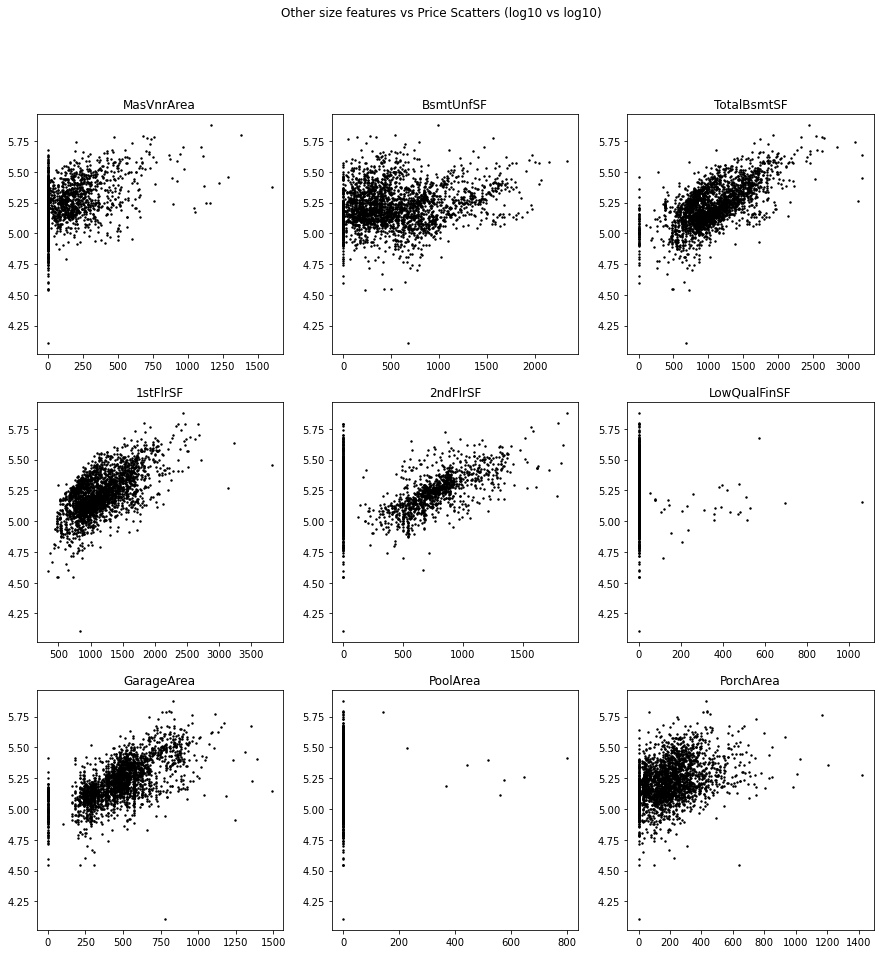

In [28]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Other size features vs Price Scatters (log10 vs log10)')

for idx, COL in enumerate(size_related.drop(['GrLivArea','LotArea'],axis=1).columns):
    ax[idx//3,idx%3].scatter(x=size_related[COL],y=np.log10(y), s=2,c='k')
    ax[idx//3,idx%3].set_title(str(COL))

## 📉 Prepare for Multiple Regression

In [30]:
X = data[['MSSubClass','GarageCars', 'BsmtQual','Foundation', 'PavedDrive', 'AllBath', 'TotRmsAbvGrd', 
         'Fireplaces', 'HeatingQC','Neighborhood', 'YearBuilt', 'OverallQual']]

In [31]:
X = X.join(size_related[['1stFlrSF','2ndFlrSF','GarageArea','PorchArea']],on='PID')

In [32]:
X_dum = pd.get_dummies(X, drop_first=True)

In [33]:
X_dum.isna().sum(axis=0).sum()

0

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.25)

In [35]:
lasso = Lasso(normalize=True)

In [36]:
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.8775478607195488

In [37]:
#try different alphas
alphas = np.linspace(0.00001,0.005,400)
coefs_lasso = []
R2_train = []
R2_test = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, np.log10(y_train))
    coefs_lasso.append(lasso.coef_)
    R2_train.append(lasso.score(X_train, np.log10(y_train)))
    R2_test.append(lasso.score(X_test, np.log10(y_test)))

In [38]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train.columns)
R2_lasso = pd.DataFrame({'train': R2_train,'test':R2_test}, index = alphas)
coefs_lasso.head(2)

,GarageCars,AllBath,TotRmsAbvGrd,Fireplaces,YearBuilt,OverallQual,1stFlrSF,2ndFlrSF,GarageArea,PorchArea,MSSubClass_2FL,MSSubClass_DUP2FAM,MSSubClass_PUD1Fl,MSSubClass_PUD2Fl,MSSubClass_SPLIT,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_Po,BsmtQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,PavedDrive_P,PavedDrive_Y,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0.000010,0.009390,0.024493,0.000520,0.017164,0.000612,0.037260,0.000124,0.000070,0.000038,0.000049,0.0,-0.040418,-0.030433,-0.063979,0.0,-0.019537,-0.0,-0.0,0.0,0.018814,0.018852,-0.034111,-0.007582,-0.0,0.022724,0.033408,-0.045842,-0.007091,-0.096793,-0.025083,-0.0,-0.017725,0.0,0.039043,0.00049,0.060701,-0.018185,-0.008643,0.02991,0.188481,-0.021176,-0.0,-0.032342,0.001238,-0.002974,-0.0,-0.001329,0.024452,0.043253,-0.014780,-0.019203,0.0,-0.01372,0.024899,0.066309,0.015084,0.016359
0.000023,0.008528,0.024538,0.000686,0.017556,0.000672,0.038093,0.000123,0.000067,0.000044,0.000049,0.0,-0.038424,-0.024897,-0.059964,0.0,-0.017830,-0.0,-0.0,0.0,0.011427,0.012056,-0.037374,-0.003662,-0.0,0.015771,0.030267,-0.042019,-0.004634,-0.069774,-0.022733,-0.0,-0.013809,0.0,0.035546,0.00000,0.059090,-0.014063,-0.005222,0.01366,0.165835,-0.017522,-0.0,-0.027488,0.000000,-0.000000,-0.0,-0.000000,0.021784,0.037333,-0.012143,-0.013877,0.0,-0.01078,0.020590,0.057177,0.010857,0.008981


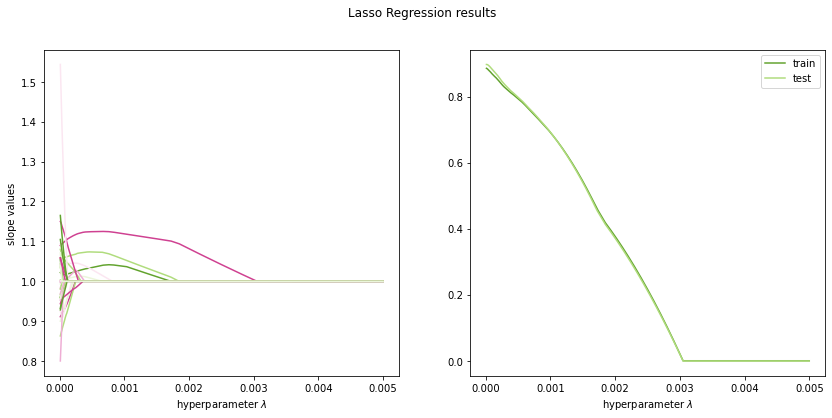

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lasso Regression results')

for feat in coefs_lasso.columns:
    ax1.plot(coefs_lasso.index, 10**coefs_lasso[feat]) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'slope values')
#ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)

## 🌲 Prepare for RandomForest

In [40]:
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder

#### Label Encode instead of Dummifying

In [45]:
X_le = X.copy()
X_le.columns

Index(['MSSubClass', 'GarageCars', 'BsmtQual', 'Foundation', 'PavedDrive',
       'AllBath', 'TotRmsAbvGrd', 'Fireplaces', 'HeatingQC', 'Neighborhood',
       'YearBuilt', 'OverallQual', '1stFlrSF', '2ndFlrSF', 'GarageArea',
       'PorchArea'],
      dtype='object')

In [68]:
# Use LabelEncoder on Categorical features
le = LabelEncoder()
X_le.MSSubClass = le.fit_transform(X.MSSubClass)
X_le.Foundation = le.fit_transform(X.Foundation)
X_le.PavedDrive = le.fit_transform(X.PavedDrive)
X_le.Neighborhood = le.fit_transform(X.Neighborhood)

In [62]:
# Manually Encode Ordinal features
X_le.BsmtQual = X_le.BsmtQual.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5,np.NaN:0})
X_le.HeatingQC = X_le.HeatingQC.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_le, y, test_size=0.25)

In [70]:
forest = ensemble.RandomForestRegressor()
forest.set_params(n_estimators=50, random_state=42, max_features=10)
forest.fit(X_train, y_train)
print("The training r2: %.5f" %(forest.score(X_train, y_train)))
print("The test     r2: %.5f" %(forest.score(X_test, y_test)))

The training r2: 0.98301
The test     r2: 0.85818


## Bad overfit and test error
* Use GridSearchCV to tune Parameters

In [72]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 10,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [71]:
from sklearn.model_selection import GridSearchCV

In [74]:
grid_para_forest = [{
    "max_depth": np.linspace(start=6, stop=30, num=13, dtype=int),
    "min_samples_split": np.linspace(start=6, stop=30, num=13, dtype=int)}]
gs_forest = GridSearchCV(forest, grid_para_forest, scoring='r2', cv=5, n_jobs=-1)
%time gs_forest.fit(X_train, y_train)

Wall time: 47.7 s


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features=10, n_estimators=50,
                                             random_state=42),
             n_jobs=-1,
             param_grid=[{'max_depth': array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]),
                          'min_samples_split': array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
             scoring='r2')

In [75]:
gs_forest.best_params_

{'max_depth': 14, 'min_samples_split': 6}

In [76]:
print("The training r2: %.5f" % (gs_forest.score(X_train, y_train)))
print("The test     r2: %.5f" % (gs_forest.score(X_test, y_test)))

The training r2: 0.97089
The test     r2: 0.86108


In [77]:
pd.DataFrame({'Feat':X_train.columns,'Importance':gs_forest.best_estimator_.feature_importances_}).\
sort_values(by='Importance', ascending=False)

,Feat,Importance
11,OverallQual,0.469957
12,1stFlrSF,0.118592
5,AllBath,0.100656
10,YearBuilt,0.064249
14,GarageArea,0.060183
1,GarageCars,0.058546
13,2ndFlrSF,0.037437
15,PorchArea,0.019390
6,TotRmsAbvGrd,0.017940
7,Fireplaces,0.015111


## 🚀 Prepare for Boosting

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

In [80]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
gbm.score(X_test, y_test)

0.8456042572054958

In [81]:
gbm.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [84]:
grid_para_boost = [{
    "learning_rate":[0.1,0.25,0.5,1],
    "max_depth": np.linspace(start=6, stop=30, num=13, dtype=int)}]
gs_boost = GridSearchCV(gbm, grid_para_boost, scoring='r2', cv=5, n_jobs=-1)
%time gs_boost.fit(X_train, y_train)

Wall time: 1min 5s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.1, 0.25, 0.5, 1],
                          'max_depth': array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
             scoring='r2')

In [86]:
gs_boost.best_params_

{'learning_rate': 0.1, 'max_depth': 6}

In [87]:
print("The training r2: %.5f" % (gs_boost.score(X_train, y_train)))
print("The test     r2: %.5f" % (gs_boost.score(X_test, y_test)))

The training r2: 0.98794
The test     r2: 0.85014
